<a href="https://colab.research.google.com/github/hallelujahylefay/limit_order_book/blob/efearase-patch-1/benchmark_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import catboost as cb
import tensorflow as tf
import optuna
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [4]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[column]>num][column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
        indicator.append(1 if len(arr[arr>i]) else 0)
    return time, indicator

In [5]:
df['time'], df['indicator'] = finder_of_fulfilment(df, 'ask_prices_0')
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,bid_prices_3,ask_prices_3,bid_quantity_3,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.287121920,1
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.135131904,1
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.092182016,1
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:04.031494144,1
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:03.939522816,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,27967.27,27971.29,0.271732,0.214506,27966.76,27971.32,0.452887,0.028795,0 days 23:49:47.846328064,0
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.27,27971.32,0.271732,0.028795,0 days 23:49:47.845549056,0
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.28,27971.32,0.040000,0.028795,0 days 23:49:47.841787136,0
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.28,0.072000,0.040000,27967.28,27971.29,0.040000,0.214506,0 days 23:49:47.841325056,0


In [6]:
df['time'] = round((df['time']).dt.total_seconds().astype(float),2)
df = df.iloc[0:-140]
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,bid_prices_3,ask_prices_3,bid_quantity_3,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,4.29,1
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,4.14,1
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,4.09,1
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,4.03,1
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,3.94,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102941,2023-10-02 00:10:11.050308096,27967.97,27970.27,0.072713,0.214514,27967.67,27974.50,0.040000,2.196920,27967.50,...,27967.27,27976.01,0.608338,0.161392,27967.26,27976.07,0.399050,0.342897,0.01,1
102942,2023-10-02 00:10:11.051523840,27967.97,27970.27,0.072713,0.214514,27967.67,27974.50,0.040000,2.196920,27967.50,...,27967.26,27976.01,0.399050,0.161392,27967.25,27976.07,0.040000,0.342897,0.01,1
102943,2023-10-02 00:10:11.056466944,27967.97,27969.69,0.072713,0.020000,27967.67,27970.27,0.040000,0.214514,27967.50,...,27967.26,27975.28,0.399050,0.250000,27967.25,27976.01,0.040000,0.161392,0.01,1
102944,2023-10-02 00:10:11.056470016,27967.97,27969.69,0.072713,0.020000,27967.67,27970.27,0.040000,0.214514,27967.50,...,27967.27,27975.28,0.020000,0.250000,27967.26,27976.01,0.399050,0.161392,0.01,1


In [13]:
times = np.sort(df['time'].unique())
times

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 8.621607e+04,
       8.621608e+04, 8.621609e+04])

In [15]:
df_to_plot = df[['indicator', 'time']]
N = len(df_to_plot)
times = np.sort(df['time'].unique())
S_of_t = []

for time in times:
    num_executed = len(df_to_plot[df_to_plot['time']==time])
    num_survived = len(df_to_plot[df_to_plot['time']>time])
    prob = num_executed/(num_survived+num_executed)
    S_of_t.append(1-prob)

In [16]:
S_hat = np.cumprod(S_of_t)

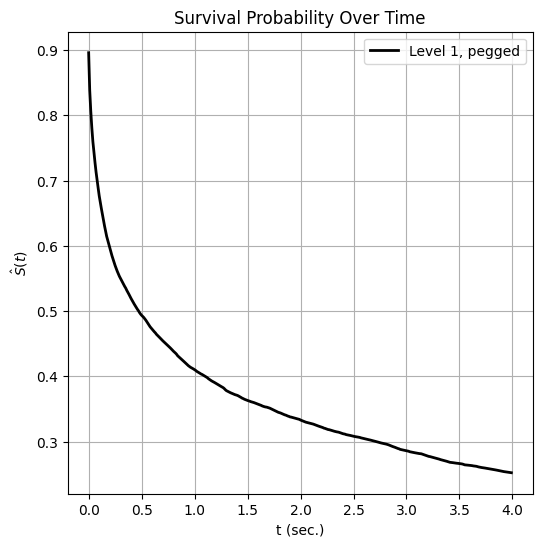

In [19]:
t = times[:400]

plt.figure(figsize=(6, 6))
plt.plot(t, S_hat[:400], linewidth=2, label='Level 1, pegged', color='black')
plt.xlabel('t (sec.)')
plt.ylabel('$\hat{S}(t)$')
plt.title('Survival Probability Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

Vol is 0.14% per second
Vol is 8.54% per hour
Vol is 41.82% per day
Vol is 799.25% per year


In [21]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

In [24]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator,vol_imbalance,microprice,daily_volatility
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,0.500000,27993.73,27998.06,0.186802,0.161504,4.29,1,0.890551,27995.450547,NaN
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,27993.73,27998.06,0.186802,0.161504,4.14,1,0.890551,27995.450547,NaN
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.500000,27993.73,27998.06,0.186802,0.161504,4.09,1,0.751171,27995.451244,NaN
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.001200,27993.73,27998.00,0.186802,0.500000,4.03,1,0.751171,27995.451244,NaN
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.001200,27993.73,27998.00,0.186802,0.500000,3.94,1,0.751894,27995.451241,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102941,2023-10-02 00:10:11.050308096,27967.97,27970.27,0.072713,0.214514,27967.67,27974.50,0.040000,2.196920,27967.50,...,0.161392,27967.26,27976.07,0.399050,0.342897,0.01,1,-0.493688,27969.687741,74.114240
102942,2023-10-02 00:10:11.051523840,27967.97,27970.27,0.072713,0.214514,27967.67,27974.50,0.040000,2.196920,27967.50,...,0.161392,27967.25,27976.07,0.040000,0.342897,0.01,1,-0.493688,27969.687741,74.114250
102943,2023-10-02 00:10:11.056466944,27967.97,27969.69,0.072713,0.020000,27967.67,27970.27,0.040000,0.214514,27967.50,...,0.250000,27967.25,27976.01,0.040000,0.161392,0.01,1,0.568562,27968.341037,74.155389
102944,2023-10-02 00:10:11.056470016,27967.97,27969.69,0.072713,0.020000,27967.67,27970.27,0.040000,0.214514,27967.50,...,0.250000,27967.26,27976.01,0.399050,0.161392,0.01,1,0.568562,27968.341037,74.155396


In [25]:
df.dropna(inplace=True)
df.describe()

,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,ask_prices_2,...,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator,vol_imbalance,microprice,daily_volatility
count,101947.000000,101947.000000,1.019470e+05,1.019470e+05,101947.000000,101947.000000,1.019470e+05,101947.000000,101947.000000,101947.000000,...,101947.000000,101947.000000,101947.000000,1.019470e+05,101947.000000,101947.000000,101947.000000,101947.000000,101947.000000,101947.000000
mean,27990.320536,27991.964960,1.731906e-01,1.680771e-01,27989.795435,27992.564641,1.938435e-01,0.155036,27989.398997,27993.076114,...,0.163587,27988.650866,27993.983949,1.966629e-01,0.171117,2720.299044,0.968493,0.006755,27991.148895,213.917624
std,28.831375,28.968102,2.868469e-01,4.306384e-01,28.762955,29.000073,3.352286e-01,0.514549,28.710048,29.021880,...,0.383343,28.643877,29.097592,3.220695e-01,0.381018,15049.298697,0.174683,0.636954,28.899126,359.655904
min,27938.200000,27938.980000,3.000000e-08,1.000000e-08,27936.380000,27938.990000,3.500000e-07,0.000002,27936.270000,27939.270000,...,0.000002,27934.010000,27939.450000,3.500000e-07,0.000002,0.000000,0.000000,-1.000000,27938.219139,8.214423
25%,27965.630000,27967.610000,4.000000e-02,4.000000e-02,27965.120000,27968.370000,4.658155e-02,0.045000,27964.610000,27969.095000,...,0.040000,27963.940000,27969.880000,4.000000e-02,0.040000,0.050000,1.000000,-0.571189,27966.546381,32.976904
50%,27990.430000,27991.220000,8.000000e-02,7.271321e-02,27989.700000,27991.980000,8.927587e-02,0.072713,27989.120000,27992.410000,...,0.078324,27988.350000,27993.350000,8.923631e-02,0.089620,0.480000,1.000000,0.008086,27990.780550,59.304350
75%,28013.260000,28014.830000,2.500000e-01,2.418878e-01,28012.420000,28015.050000,2.500000e-01,0.212259,28012.170000,28015.100000,...,0.214416,28010.990000,28015.820000,2.500000e-01,0.214430,4.170000,1.000000,0.580869,28013.983437,188.536069
max,28057.990000,28058.000000,5.000000e+00,1.874256e+01,28057.550000,28062.620000,5.000000e+00,18.742559,28057.540000,28062.900000,...,18.742559,28057.000000,28065.430000,5.000000e+00,18.742559,86216.090000,1.000000,1.000000,28058.000000,2006.112857


In [33]:
N = 100 # define the number of previous observations included

X = df.drop(columns=['timestamp', 'time', 'indicator'])
Y = df['time'].values
print(Y.shape)

(101947,)


In [ ]:
model = cb.CatBoostRegressor(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    loss_function='RMSE'
)

model.fit(X, Y)

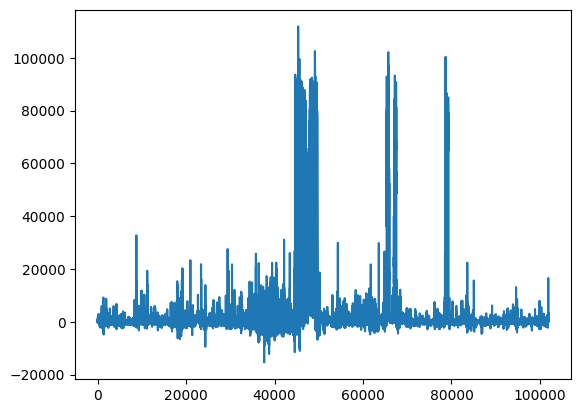

In [36]:
Y_bench = model.predict(X)
plt.plot(Y_bench)

In [41]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
    }

    model = cb.CatBoostRegressor(**params, loss_function='RMSE', verbose=0)
    model.fit(X, Y, eval_set=[(X, Y)], early_stopping_rounds=100)

    evals_result = model.get_evals_result()
    # Assuming you have a validation RMSE, adjust the key as needed
    val_loss = evals_result['validation']['RMSE'][-5:]
    return sum(val_loss) / len(val_loss)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_params = study.best_params
print("Best parameters:", best_params)

In [ ]:
final_model = cb.CatBoostRegressor(**best_params, loss_function='RMSE')
final_model.fit(X, Y, )

In [ ]:
!pip install shap

In [54]:
final_model.fit(X, Y)
Y_pred = model.predict(X)

618:	learn: 965.1199782	total: 1m 27s	remaining: 42.9s
619:	learn: 964.2084208	total: 1m 28s	remaining: 42.8s
620:	learn: 963.6300796	total: 1m 28s	remaining: 42.7s
621:	learn: 963.0599317	total: 1m 28s	remaining: 42.6s
622:	learn: 962.0948867	total: 1m 28s	remaining: 42.5s
623:	learn: 960.8451601	total: 1m 29s	remaining: 42.4s
624:	learn: 959.5411494	total: 1m 29s	remaining: 42.3s
625:	learn: 958.8888040	total: 1m 29s	remaining: 42.2s
626:	learn: 957.8255433	total: 1m 29s	remaining: 42.1s
627:	learn: 956.4313395	total: 1m 29s	remaining: 42s
628:	learn: 955.6058940	total: 1m 30s	remaining: 41.9s
629:	learn: 954.6297477	total: 1m 30s	remaining: 41.7s
630:	learn: 953.6646251	total: 1m 30s	remaining: 41.6s
631:	learn: 953.0935948	total: 1m 30s	remaining: 41.5s
632:	learn: 952.1337901	total: 1m 30s	remaining: 41.4s
633:	learn: 951.3448460	total: 1m 31s	remaining: 41.3s
634:	learn: 950.2485508	total: 1m 31s	remaining: 41.1s
635:	learn: 949.5107396	total: 1m 31s	remaining: 41s
636:	learn: 94

In [45]:
import shap

In [46]:
explainer = shap.TreeExplainer(final_model)

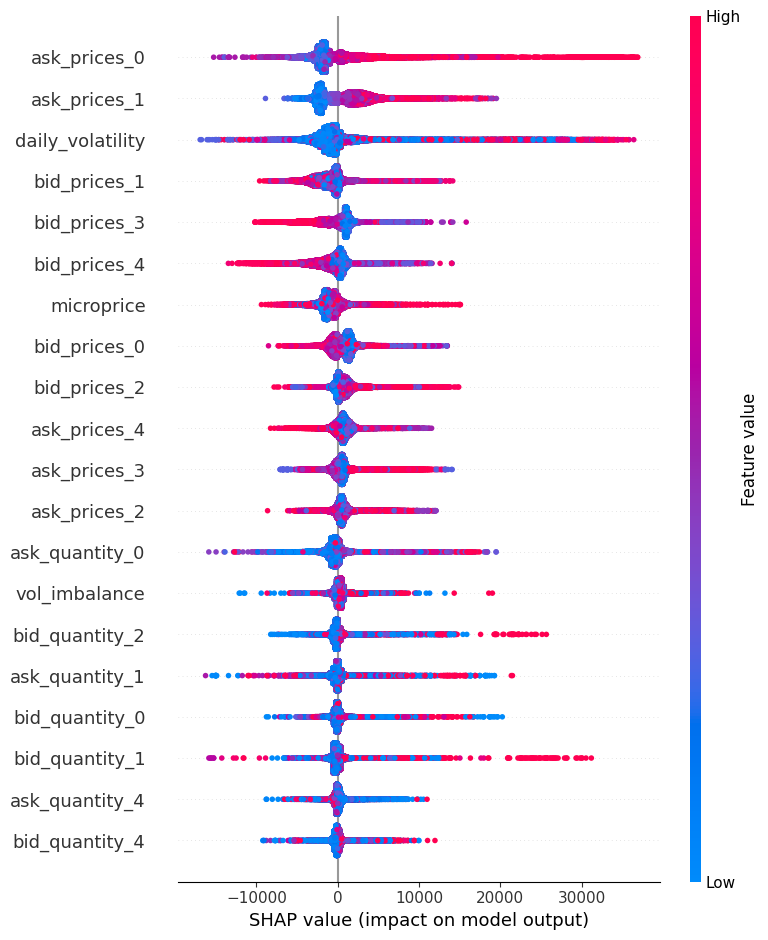

In [48]:
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

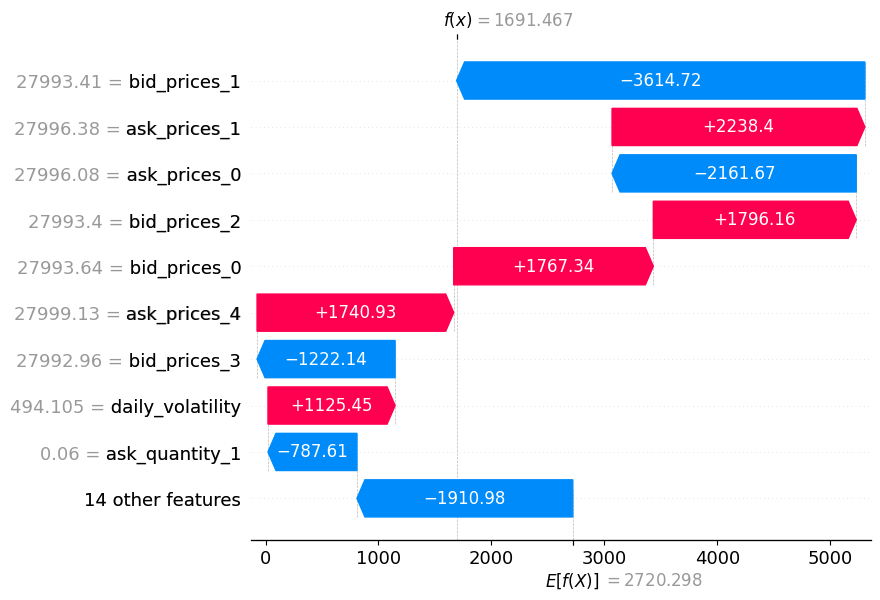

In [52]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,  # or a subset of X for large datasets
    feature_names=X.columns,  # replace with your actual feature names
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])

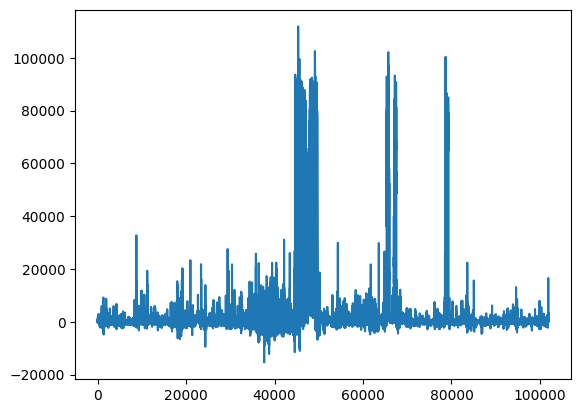

In [56]:
plt.plot(Y_pred)